<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/Causal_Impact_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
!pip install git+https://github.com/jamalsenouci/causalimpact.git

  Cloning https://github.com/jamalsenouci/causalimpact.git to /tmp/pip-req-build-dr5umgpr
  Running command git clone -q https://github.com/jamalsenouci/causalimpact.git /tmp/pip-req-build-dr5umgpr


In [122]:
from causalimpact import CausalImpact
import pandas as pd
import io
from google.colab import files  
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [147]:
df = pd.DataFrame()
df2 = pd.DataFrame()
df2['x1'] = np.random.normal(0,4, 45) + np.linspace(0,15,45)
df['y'] = np.random.normal(0,3,45) + np.linspace(0,15, 45) + np.append(np.zeros(30), np.random.normal(15,3,15))
df['y'] = df['y'] +  np.append(np.zeros(40), np.asarray([-15]*5))
df['y'] = df['y'] +  np.append(np.zeros(43), np.asarray([-5]*2))

189.1307872318758


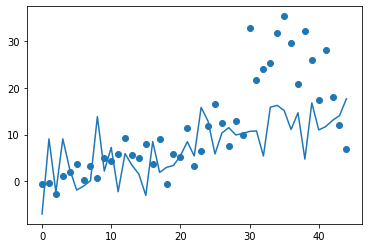

In [148]:
plt.scatter(np.linspace(0,44,45),df['y'])
plt.plot(np.linspace(0,44,45),df2['x1'])
print(sum(df['y']) - sum(df2['x1']))

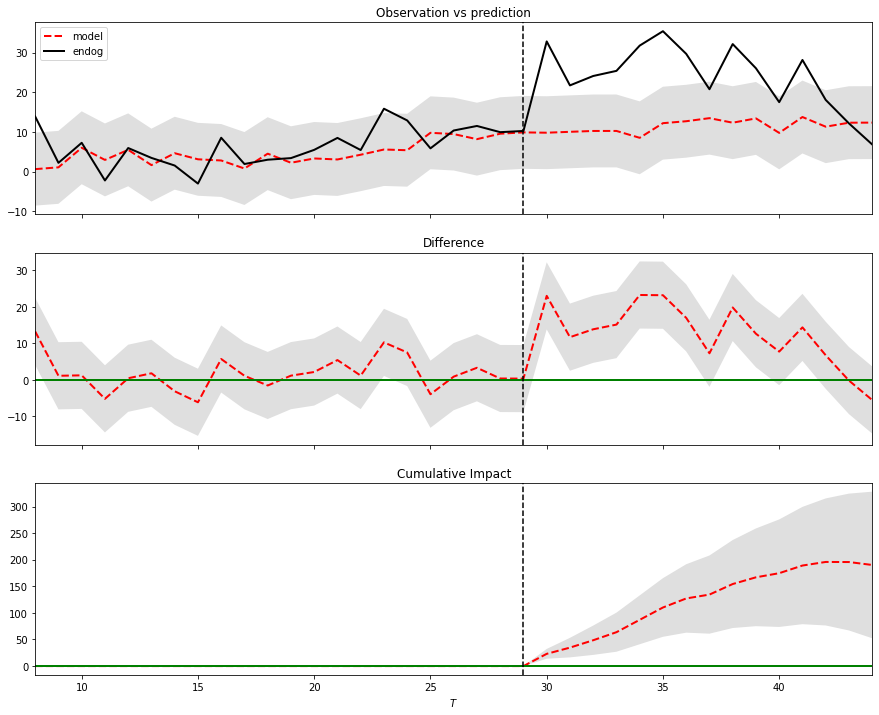

In [149]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
ucm_model = UnobservedComponents(endog=df2['x1'][0:45], exog=df['y'][0:45],  autoregressive=1,
                               level='llevel')
impact = CausalImpact(ucm_model=ucm_model, post_period_response=df['y'][30::])
impact.run()
#TODO
impact.plot()

In [150]:

impact.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                     x1   No. Observations:                   45
Model:                    local level   Log Likelihood                -130.980
                              + AR(1)   AIC                            271.960
Date:                Wed, 25 Aug 2021   BIC                            280.881
Time:                        05:18:27   HQIC                           275.268
Sample:                             0                                         
                                 - 45                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     9.9521      9.446      1.054      0.292      -8.561      28.465
sigma2.level         1.3298      1.338      0.994      0.320      -1.292       3.951
sigma2.ar            3.9016      7.367      0.530      0.596     -10.538      18.341
ar.L1               -0.7189      0.354     -2.030      0.042      -1.413      -0.025
beta.y              -0.0002      0.152     -0.001      0.999      -0.299       0.299
===================================================================================
Ljung-Box (Q):                       32.66   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.79   Prob(JB):                         0.61
Heteroskedasticity (H):               0.51   Skew:                             0.34
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
import numpy as np
import pandas as pd
from pandas._libs.tslibs.timestamps import Timestamp
from pandas.api.types import is_list_like

from causalimpact.misc import (
    standardize_all_variables,
    df_print,
    get_matplotlib
)
from causalimpact.model import construct_model, model_fit
from causalimpact.inferences import compile_posterior_inferences




class CausalImpact(object):

    def __init__(self, data=None, pre_period=None, post_period=None,
                 model_args=None, ucm_model=None, post_period_response=None,
                 alpha=0.05, estimation="MLE"):
        self.series = None
        self.model = {}
        if isinstance(data, pd.DataFrame):
            self.data = data.copy()
        else:
            self.data = data
        self.params = {"data": data, "pre_period": pre_period,
                       "post_period": post_period, "model_args": model_args,
                       "ucm_model": ucm_model,
                       "post_period_response": post_period_response,
                       "alpha": alpha, "estimation": estimation}

    def run(self):
        kwargs = self._format_input(self.params["data"],
                                    self.params["pre_period"],
                                    self.params["post_period"],
                                    self.params["model_args"],
                                    self.params["ucm_model"],
                                    self.params["post_period_response"],
                                    self.params["alpha"])

        # Depending on input, dispatch to the appropriate Run* method()
        if self.data is not None:
            self._run_with_data(kwargs["data"], kwargs["pre_period"],
                                kwargs["post_period"], kwargs["model_args"],
                                kwargs["alpha"], self.params["estimation"])
        else:
            self._run_with_ucm(kwargs["ucm_model"],
                               kwargs["post_period_response"],
                               kwargs["alpha"], kwargs["model_args"],
                               self.params["estimation"])

    def _format_input_data(self, data):
        """Check and format the data argument provided to CausalImpact().
        Args:
            data: Pandas DataFrame
        Returns:
            correctly formatted Pandas DataFrame
        """
        # If <data> is a Pandas DataFrame and the first column is 'date',
        # try to convert

        if type(data) == pd.DataFrame and type(data.columns[0]) == str:
            if data.columns[0].lower() in ["date", "time"]:
                data = data.set_index(data.columns[0])

        # Try to convert to Pandas DataFrame
        try:
            data = pd.DataFrame(data)
        except ValueError:
            raise ValueError("could not convert input data to Pandas " +
                              "DataFrame")

        # Must have at least 3 time points
        if len(data.index) < 3:
            raise ValueError("data must have at least 3 time points")

        # Must not have NA in covariates (if any)
        if len(data.columns) >= 2:
            if pd.isnull(data.iloc[:, 1:]).any(axis=None):
                raise ValueError("covariates must not contain null values")

        return data

    def _format_input_prepost(self, pre_period, post_period, data):
        """Check and format the pre_period and post_period input arguments.
        Args:
            pre_period: two-element list
            post_period: two-element list
            data: already-checked Pandas DataFrame, for reference only
        """
        import numpy as np
        import pandas as pd
        if type(pre_period) is not list or type(post_period) is not list:
            raise ValueError("pre_period and post_period must both be lists")
        if len(pre_period) != 2 or len(post_period) != 2:
            raise ValueError("pre_period and post_period must both be of " +
                             "length 2")
        if pd.isnull(pre_period).any(axis=None) or pd.isnull(post_period).any(axis=None):
            raise ValueError("pre_period and post period must not contain " +
                             "null values")

        pre_dtype = np.array(pre_period).dtype
        post_dtype = np.array(post_period).dtype
        if isinstance(data.index, pd.core.indexes.datetimes.DatetimeIndex):
            pre_period = [pd.to_datetime(date) for date in pre_period]
            post_period = [pd.to_datetime(date) for date in post_period]
        elif pre_dtype == 'O' or post_dtype == "O":
            raise ValueError("pre_period (" + pre_dtype.name +
                             ") and post_period (" + post_dtype.name +
                             ") should have the same class as the " +
                             "time points in the data (" +
                             data.index.dtype.name + ")")

        elif data.index.dtype.kind != pre_dtype.kind or \
                data.index.dtype.kind != post_dtype.kind:
            if data.index.dtype == int:
                pre_period = [int(elem) for elem in pre_period]
                post_period = [int(elem) for elem in post_period]
            elif data.index.dtype == float:
                pre_period = [float(elem) for elem in pre_period]
                post_period = [float(elem) for elem in post_period]
            else:
                raise ValueError("pre_period (" + pre_dtype.name +
                                 ") and post_period (" + post_dtype.name +
                                 ") should have the same class as the " +
                                 "time points in the data (" +
                                 data.index.dtype.name + ")")

        if pre_period[1] > post_period[0]:
            raise ValueError("post period must start at least 1 observation" +
                             " after the end of the pre_period")

        if isinstance(data.index, pd.RangeIndex):
            loc3 = post_period[0]
            loc4 = post_period[1]
        else:
            loc3 = data.index.get_loc(post_period[0])
            loc4 = data.index.get_loc(post_period[1])

        if loc4 < loc3:
            raise ValueError("post_period[1] must not be earlier than " +
                             "post_period[0]")

        if pre_period[0] < data.index.min():
            pre_period[0] = data.index.min()

        if post_period[1] > data.index.max():
            post_period[1] = data.index.max()

        return {"pre_period": pre_period, "post_period": post_period}

    def _format_input(self, data, pre_period, post_period, model_args,
                      ucm_model, post_period_response, alpha):
        """Check and format all input arguments supplied to CausalImpact().
           See the documentation of CausalImpact() for details
        Args:
            data:                 Pandas DataFrame or data frame
            pre_period:           beginning and end of pre-period
            post_period:          beginning and end of post-period
            model_args:           dict of additional arguments for the model
            ucm_model:            UnobservedComponents model (instead of data)
            post_period_response: observed response in the post-period
            alpha:                tail-area for posterior intervals
            estimation:           method of estimation for model fitting
        Returns:
            list of checked (and possibly reformatted) input arguments
        """

        import numpy as np
        import pandas as pd

        # Check that a consistent set of variables has been provided
        args = [data, pre_period, post_period, ucm_model,
                post_period_response]

        data_model_args = [True, True, True, False, False]
        ucm_model_args = [False, False, False, True, True]

        if np.any(pd.isnull(args) != data_model_args) and \
           np.any(pd.isnull(args) != ucm_model_args):
            raise SyntaxError("Must either provide ``data``, ``pre_period``" +
                              " ,``post_period``, ``model_args``"
                              " or ``ucm_model" +
                              "and ``post_period_response``")

        # Check <data> and convert to Pandas DataFrame, with rows
        # representing time points
        if data is not None:
            data = self._format_input_data(data)

        # Check <pre_period> and <post_period>
        if data is not None:
            checked = self._format_input_prepost(pre_period, post_period, data)
            pre_period = checked["pre_period"]
            post_period = checked["post_period"]

        # Parse <model_args>, fill gaps using <_defaults>

        _defaults = {"niter": 1000, "standardize_data": True,
                     "prior_level_sd": 0.01,
                     "nseasons": 1,
                     "season_duration": 1,
                     "dynamic_regression": False}

        if model_args is None:
            model_args = _defaults
        else:
            missing = [key for key in _defaults if key not in model_args]
            for arg in missing:
                model_args[arg] = _defaults[arg]

        """ Check only those parts of <model_args> that are used
            in this file The other fields will be checked in
            FormatInputForConstructModel()"""

        # Check <standardize_data>
        if type(model_args["standardize_data"]) != bool:
            raise ValueError("model_args.standardize_data must be a" +
                             " boolean value")

        """ Check <ucm_model> TODO
        if ucm_model is not None:
            if type(ucm_model) != ucm:
                raise ValueError("ucm_model must be an object of class \
                                 statsmodels_ucm")
        """

        # Check <post_period_response>
        if ucm_model is not None:
            if not is_list_like(post_period_response):
                raise ValueError("post_period_response must be list-like")
            if np.array(post_period_response).dtype.num == 17:
                raise ValueError("post_period_response should not be" +
                                 " datetime values")
            if not np.all(np.isreal(post_period_response)):
                raise ValueError("post_period_response must contain all" +
                                 " real values")

        # Check <alpha>
        if alpha is None:
            raise ValueError("alpha must not be None")
        if not np.isreal(alpha):
            raise ValueError("alpha must be a real number")
        if np.isnan(alpha):
            raise ValueError("alpha must not be NA")
        if alpha <= 0 or alpha >= 1:
            raise ValueError("alpha must be between 0 and 1")

        # Return updated arguments
        kwargs = {"data": data, "pre_period": pre_period,
                  "post_period": post_period, "model_args": model_args,
                  "ucm_model": ucm_model,
                  "post_period_response": post_period_response, "alpha": alpha}
        return kwargs

    def _run_with_data(self, data, pre_period, post_period, model_args, alpha,
                       estimation):
        # Zoom in on data in modeling range
        if data.shape[1] == 1:  # no exogenous values provided
            raise ValueError("data contains no exogenous variables")
        data_modeling = data.copy()

        df_pre = data_modeling.loc[pre_period[0]:pre_period[1], :]
        df_post = data_modeling.loc[post_period[0]:post_period[1], :]

        # Standardize all variables
        orig_std_params = (0, 1)
        if model_args["standardize_data"]:
            sd_results = standardize_all_variables(data_modeling, pre_period,
                                                   post_period)
            df_pre = sd_results["data_pre"]
            df_post = sd_results["data_post"]
            orig_std_params = sd_results["orig_std_params"]

        # Construct model and perform inference
        model = construct_model(df_pre, model_args)
        self.model = model

        trained_model = model_fit(model, estimation, model_args["niter"])
        self.model = trained_model

        inferences = compile_posterior_inferences(trained_model, data, df_pre,
                                                  df_post, None, alpha,
                                                  orig_std_params, estimation)

        # "append" to 'CausalImpact' object
        self.inferences = inferences["series"]

    def _run_with_ucm(self, ucm_model, post_period_response, alpha, model_args,
                      estimation):
        """ Runs an impact analysis on top of a ucm model.
           Args:
             ucm_model: Model as returned by UnobservedComponents(),
                        in which the data during the post-period was set to NA
             post_period_response: observed data during the post-intervention
                                   period
             alpha: tail-probabilities of posterior intervals"""
        # Guess <pre_period> and <post_period> from the observation vector
        # These will be needed for plotting period boundaries in plot().
        #raise NotImplementedError()

        """
        try:
            indices = infer_period_indices_from_data(y)
        except ValueError:
            raise ValueError("ucm_model must have been fitted on data where " +
                             "the values in the post-intervention period " +
                             "have been set to NA")
        """

        df_pre = ucm_model.data.orig_endog[:-len(post_period_response)]
        df_pre = pd.DataFrame(df_pre)

        post_period_response = pd.DataFrame(post_period_response)

        data = pd.DataFrame(np.concatenate([df_pre.values,
            post_period_response.values]))

        orig_std_params = (0, 1)

        fitted_model = model_fit(ucm_model, estimation,
            model_args["niter"])

        # Compile posterior inferences
        inferences = compile_posterior_inferences(
            fitted_model,
            data,
            df_pre,
            None,
            post_period_response,
            alpha,
            orig_std_params,
            estimation
        )

        obs_inter = fitted_model.model.nobs - len(
            post_period_response)

        self.params["pre_period"] = [0, obs_inter - 1]
        self.params["post_period"] = [obs_inter, -1]
        self.data = pd.concat([df_pre, post_period_response])
        self.inferences = inferences["series"]
        self.model = fitted_model

    def summary(self, output="summary", width=120, path=None):
        import textwrap
        import scipy.stats as st

        alpha = self.params["alpha"]
        confidence = "{}%".format(int((1 - alpha) * 100))
        post_period = self.params["post_period"]
        post_inf = self.inferences.loc[post_period[0]:post_period[1], :]
        post_point_resp = post_inf.loc[:, "response"]
        post_point_pred = post_inf.loc[:, "point_pred"]
        post_point_upper = post_inf.loc[:, "point_pred_upper"]
        post_point_lower = post_inf.loc[:, "point_pred_lower"]

        mean_resp = post_point_resp.mean()
        mean_resp_fmt = int(mean_resp)
        cum_resp = post_point_resp.sum()
        cum_resp_fmt = int(cum_resp)
        mean_pred = post_point_pred.mean()
        mean_pred_fmt = int(post_point_pred.mean())
        cum_pred = post_point_pred.sum()
        cum_pred_fmt = int(cum_pred)
        mean_lower = post_point_lower.mean()
        mean_lower_fmt = int(mean_lower)
        mean_upper = post_point_upper.mean()
        mean_upper_fmt = int(mean_upper)
        mean_ci_fmt = [mean_lower_fmt, mean_upper_fmt]
        cum_lower = post_point_lower.sum()
        cum_lower_fmt = int(cum_lower)
        cum_upper = post_point_upper.sum()
        cum_upper_fmt = int(cum_upper)
        cum_ci_fmt = [cum_lower_fmt, cum_upper_fmt]

        abs_effect = (post_point_resp - post_point_pred).mean()
        abs_effect_fmt = int(abs_effect)
        cum_abs_effect = (post_point_resp - post_point_pred).sum()
        cum_abs_effect_fmt = int(cum_abs_effect)
        abs_effect_lower = (post_point_resp - post_point_lower).mean()
        abs_effect_lower_fmt = int(abs_effect_lower)
        abs_effect_upper = (post_point_resp - post_point_upper).mean()
        abs_effect_upper_fmt = int(abs_effect_upper)
        abs_effect_ci_fmt = [abs_effect_lower_fmt, abs_effect_upper_fmt]
        cum_abs_lower = (post_point_resp - post_point_lower).sum()
        cum_abs_lower_fmt = int(cum_abs_lower)
        cum_abs_upper = (post_point_resp - post_point_upper).sum()
        cum_abs_upper_fmt = int(cum_abs_upper)
        cum_abs_effect_ci_fmt = [cum_abs_lower_fmt, cum_abs_upper_fmt]

        rel_effect = abs_effect / mean_pred * 100
        rel_effect_fmt = "{:.1f}%".format(rel_effect)
        cum_rel_effect = cum_abs_effect / cum_pred * 100
        cum_rel_effect_fmt = "{:.1f}%".format(cum_rel_effect)
        rel_effect_lower = abs_effect_lower / mean_pred * 100
        rel_effect_lower_fmt = "{:.1f}%".format(rel_effect_lower)
        rel_effect_upper = abs_effect_upper / mean_pred * 100
        rel_effect_upper_fmt = "{:.1f}%".format(rel_effect_upper)
        rel_effect_ci_fmt = [rel_effect_lower_fmt, rel_effect_upper_fmt]
        cum_rel_effect_lower = cum_abs_lower / cum_pred * 100
        cum_rel_effect_lower_fmt = "{:.1f}%".format(cum_rel_effect_lower)
        cum_rel_effect_upper = cum_abs_upper / cum_pred * 100
        cum_rel_effect_upper_fmt = "{:.1f}%".format(cum_rel_effect_upper)
        cum_rel_effect_ci_fmt = [cum_rel_effect_lower_fmt,
                                 cum_rel_effect_upper_fmt]
        
        #assuming approximately normal distribution
        #calculate standard deviation from the 95% conf interval
        std_pred = (mean_upper - mean_pred) / 1.96 # from mean_upper = mean_pred + 1.96 * std
        #calculate z score
        z_score = (0 - mean_pred) / std_pred
        #pvalue from zscore
        p_value = st.norm.cdf(z_score)
        prob_causal = (1 - p_value)
        p_value_perc = p_value  * 100
        prob_causal_perc = prob_causal * 100
        

        if output == "summary":
            # Posterior inference {CausalImpact}
            summary = [
                [mean_resp_fmt, cum_resp_fmt],
                [mean_pred_fmt, cum_pred_fmt],
                [mean_ci_fmt, cum_ci_fmt],
                [" ", " "],
                [abs_effect_fmt, cum_abs_effect_fmt],
                [abs_effect_ci_fmt, cum_abs_effect_ci_fmt],
                [" ", " "],
                [rel_effect_fmt, cum_rel_effect_fmt],
                [rel_effect_ci_fmt, cum_rel_effect_ci_fmt],
                [" ", " "],
                ["{:.1f}%".format(p_value_perc), " "],
                ["{:.1f}%".format(prob_causal_perc), " "]
            ]
            summary = pd.DataFrame(summary, columns=["Average", "Cumulative"],
                                   index=["Actual",
                                          "Predicted",
                                          "95% CI",
                                          " ",
                                          "Absolute Effect",
                                          "95% CI",
                                          " ",
                                          "Relative Effect",
                                          "95% CI",
                                          " ",
                                          "P-value",
                                          "Prob. of Causal Effect"])
            df_print(summary, path)
        elif output == "report":
            sig = (not ((cum_rel_effect_lower < 0) and
                        (cum_rel_effect_upper > 0)))
            pos = cum_rel_effect > 0
            # Summarize averages
            stmt = textwrap.dedent("""
                          During the post-intervention period, the response
                          variable had an average value of
                          approx. {mean_resp}.
                          """.format(mean_resp=mean_resp_fmt))
            if (sig):
                stmt += " By contrast, in "
            else:
                stmt += " In "

            stmt += textwrap.dedent("""
                    the absence of an intervention, we would have
                    expected an average response of {mean_pred}. The
                    {confidence} interval of this counterfactual
                    prediction is [{mean_lower}, {mean_upper}].
                    Subtracting this prediction from the observed
                    response yields an estimate of the causal effect
                    the intervention had on the response variable.
                    This effect is {abs_effect} with a
                    {confidence} interval of [{abs_lower},
                    {abs_upper}]. For a discussion of the
                    significance of this effect,
                    see below.
                    """.format(mean_pred=mean_pred_fmt,
                               confidence=confidence,
                               mean_lower=mean_lower_fmt,
                               mean_upper=mean_upper_fmt,
                               abs_effect=abs_effect_fmt,
                               abs_upper=abs_effect_upper_fmt,
                               abs_lower=abs_effect_lower_fmt))
            # Summarize sums
            stmt2 = textwrap.dedent("""
                    Summing up the individual data points during the
                    post-intervention period (which can only sometimes be
                    meaningfully interpreted), the response variable had an
                    overall value of {cum_resp}.
                    """.format(cum_resp=cum_resp_fmt))
            if (sig):
                stmt2 += " By contrast, had "
            else:
                stmt2 += " Had "

            stmt2 += textwrap.dedent("""
                    the intervention not taken place, we would have expected
                    a sum of {cum_resp}. The {confidence} interval of this
                    prediction is [{cum_pred_lower}, {cum_pred_upper}]
                    """.format(cum_resp=cum_resp_fmt,
                               confidence=confidence,
                               cum_pred_lower=cum_lower_fmt,
                               cum_pred_upper=cum_upper_fmt))

            # Summarize relative numbers (in which case row [1] = row [2])
            stmt3 = textwrap.dedent("""
                                    The above results are given in terms
                                    of absolute numbers. In relative terms, the
                                    response variable showed
                                    """)
            if (pos):
                stmt3 += " an increase of "
            else:
                stmt3 += " a decrease of "

            stmt3 += textwrap.dedent("""
                            {rel_effect}. The {confidence} interval of this
                            percentage is [{rel_effect_lower},
                            {rel_effect_upper}]
                            """.format(confidence=confidence,
                                       rel_effect=rel_effect_fmt,
                                       rel_effect_lower=rel_effect_lower_fmt,
                                       rel_effect_upper=rel_effect_upper_fmt))

            # Comment on significance
            if (sig and pos):
                stmt4 = textwrap.dedent("""
                            This means that the positive effect observed
                            during the intervention period is statistically
                            significant and unlikely to be due to random
                            fluctuations. It should be noted, however, that
                            the question of whether this increase also bears
                            substantive significance can only be answered by
                            comparing the absolute effect {abs_effect} to
                            the original goal of the underlying
                            intervention.
                            """.format(abs_effect=abs_effect_fmt))
            elif (sig and not pos):
                stmt4 = textwrap.dedent("""
                            This  means that the negative effect observed
                            during the intervention period is statistically
                            significant. If the experimenter had expected a
                            positive effect, it is recommended to double-check
                            whether anomalies in the control variables may have
                            caused an overly optimistic expectation of what
                            should have happened in the response variable in the
                            absence of the intervention.
                            """)
            elif (not sig and pos):
                stmt4 = textwrap.dedent("""
                            This means that, although the intervention
                            appears to have caused a positive effect, this
                            effect is not statistically significant when
                            considering the post-intervention period as a whole.
                            Individual days or shorter stretches within the
                            intervention period may of course still have had a
                            significant effect, as indicated whenever the lower
                            limit of the impact time series (lower plot) was
                            above zero.
                            """)
            elif (not sig and not pos):
                stmt4 = textwrap.dedent("""
                            This means that, although it may look as though
                            the intervention has exerted a negative effect on
                            the response variable when considering the
                            intervention period as a whole, this effect is not
                            statistically significant, and so cannot be
                            meaningfully interpreted.
                            """)
            if (not sig):
                stmt4 += textwrap.dedent("""
                           The apparent effect could be the result of random
                           fluctuations that are unrelated to the intervention.
                           This is often the case when the intervention period
                           is very long and includes much of the time when the
                           effect has already worn off. It can also be the case
                           when the intervention period is too short to
                           distinguish the signal from the noise. Finally,
                           failing to find a significant effect can happen when
                           there are not enough control variables or when these
                           variables do not correlate well with the response
                           variable during the learning period.""")

            print(textwrap.fill(stmt, width=width))
            print("\n")
            print(textwrap.fill(stmt2, width=width))
            print("\n")
            print(textwrap.fill(stmt3, width=width))
            print("\n")
            print(textwrap.fill(stmt4, width=width))
            '''
            if (p < summary.alpha[1]):
                stmt += """\n\nThe probability of obtaining this effect by
                           chance is very small (Bayesian one-sided tail-area
                           probability p = ", round(p, 3), "). This means the
                           causal effect can be considered statistically
                           significant."""
            else:
                stmt += """\n\nThe probability of obtaining this effect by
                           chance is p = ", round(p, 3), "). This means the effect may
                           be spurious and would generally not be considered
                           statistically significant.""".format()
            '''
        else:
            raise ValueError("Output argument must be either 'summary' " +
                             "or 'report'")

    def plot(self, panels=["original", "pointwise", "cumulative"]):
        plt = get_matplotlib()
        plt.figure(figsize=(15, 12))

        data_inter = self.params["pre_period"][1]
        if isinstance(data_inter, pd.DatetimeIndex):
            data_inter = pd.Timestamp(data_inter)

        inferences = self.inferences.iloc[8:, :] ############################ Change for seasonal model

        # Observation and regression components
        if "original" in panels:
            ax1 = plt.subplot(3, 1, 1)
            plt.plot(inferences["point_pred"], 'r--', linewidth=2,
                     label='model')
            plt.plot(inferences["response"], 'k', linewidth=2, label="endog")

            plt.axvline(data_inter, c='k', linestyle='--')

            plt.fill_between(
                inferences.index,
                inferences["point_pred_lower"],
                inferences["point_pred_upper"],
                facecolor='gray', interpolate=True, alpha=0.25,
            )
            plt.setp(ax1.get_xticklabels(), visible=False)
            plt.legend(loc='upper left')
            plt.title('Observation vs prediction')

        if "pointwise" in panels:
            # Pointwise difference
            if 'ax1' in locals():
                ax2 = plt.subplot(312, sharex=ax1)
            else:
                ax2 = plt.subplot(312)
            lift = inferences.point_effect
            plt.plot(lift, 'r--', linewidth=2)
            plt.plot(self.data.index, np.zeros(self.data.shape[0]), 'g-',
                     linewidth=2)
            plt.axvline(data_inter, c='k', linestyle='--')

            lift_lower = inferences.point_effect_lower
            lift_upper = inferences.point_effect_upper

            plt.fill_between(
                inferences.index,
                lift_lower,
                lift_upper,
                facecolor='gray', interpolate=True, alpha=0.25,
            )
            plt.setp(ax2.get_xticklabels(), visible=False)
            plt.title('Difference')

        # Cumulative impact
        if "cumulative" in panels:
            if 'ax1' in locals():
                ax3 = plt.subplot(313, sharex=ax1)
            elif 'ax2' in locals():
                ax3 = plt.subplot(313, sharex=ax2)
            else:
                ax3 = plt.subplot(313)
            plt.plot(
                inferences.index,
                inferences.cum_effect,
                'r--', linewidth=2,
            )

            plt.plot(self.data.index, np.zeros(self.data.shape[0]), 'g-',
                     linewidth=2)
            plt.axvline(data_inter, c='k', linestyle='--')

            plt.fill_between(
                inferences.index,
                inferences.cum_effect_lower,
                inferences.cum_effect_upper,
                facecolor='gray', interpolate=True, alpha=0.25,
            )
            plt.axis([inferences.index[0], inferences.index[-1], None,
                      None])

            plt.title('Cumulative Impact')
        plt.xlabel('$T$')
        plt.show()